This notebook contains the baseline models for Project [SAR](https://github.com/d0r1h/SAR), with sample dataset size of 2000


|Model | Checkpoint | Rouge-2[f_score] | checkpoint_link | Inference time | 
|--- | --- | --- | --- | --- |
|BART | ai4bharat/IndicBART | 21.48 | [🤗](https://huggingface.co/ai4bharat/IndicBART) | 20min 27s |
|T5 | csebuetnlp/mT5_multilingual_XLSum | 20.21 | [🤗](https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum) | 45min 54s|

#### **Installing dependencies**

In [2]:
!pip install transformers sentencepiece datasets rouge -qq

#### **Importing libraries**

In [3]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import plotly.express as px
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

#### **Downloading the data**

In [4]:
!wget https://raw.githubusercontent.com/d0r1h/SAR/main/dataset/SARsample.csv -q

In [5]:
data = pd.read_csv("./SARsample.csv")

In [6]:
data

,title,summary,text
0,लोकसभा चुनाव 2019: तन कर चलने वाली बीजेपी बिहा...,बिहार में भारतीय जनता पार्टी (बीजेपी) अपने सहय...,आगामी लोकसभा चुनाव में राज्य की कुल 40 सीटों म...
1,चैम्पियंस ट्रॉफी क्रिस गेल ने भारत पाकिस्तान क...,क्रिस गेल ने कहा चैंपियंस ट्रॉफी में पाकिस्तान...,वेस्टइंडीज के आक्रामक बल्लेबाज क्रिस गेल ने कह...
2,सरकार विरोधी प्रदर्शन बंद होने पर ही बातचीत स...,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...
3,वहां शेव करनी चाहिए या नहीं ट्विंकल खन्ना ने ...,ट्विंकल खन्ना ने वजाइना से जुड़े कई सवालों के ...,अकसर अपने ट्वीट्स को लेकर चर्चा में रहने वाली...
4,पैदल सड़क पार करने वाले हैं ट्रैफ़िक में बाधा?,दुनिया भर में ग़लत तरीके से सड़क पार करने पर ज...,कहा जाता है कि अमरीका में 1920 के दशक में मोटर...
...,...,...,...
1995,नोएडा नकल नहीं करवाई तो टीचर को लोहे की रॉड से...,परीक्षा में नकल करते हुए पकड़े जाने पर गुस्साए...,परीक्षा में नकल करते हुए पकड़े जाने पर गुस्साए...
1996,पाकिस्तान में दरगाह के मानसिक रूप से बीमार संर...,अलग अलग अधिकारियों ने घटना का अलग अलग कारण बता...,पाकिस्तान के पंजाब प्रांत में एक दरगाह के मानस...
1997,पांच सप्ताह की तेजी के बाद शेयर बाजारों में आई...,पांच सप्ताह लगातार तेजी में रहने के बाद गत सप्...,पांच सप्ताह लगातार तेजी में रहने के बाद गत सप्...
1998,गोपनीयता कानून के तहत सजा काटने के बाद पाकिस्त...,इसको 14 साल सश्रम कारावास की सजा सुनाई गई थी स...,तेलंगाना सरकार ने गोपनीयता कानून के तहत सजा का...


In [36]:
text = data['text']
goldsummary = data['summary']

**Note**: Mostly data is cleaned except few numerical values such as days and count, and maybe it is best not to remove them becuase summary also contains these numbers and it can be valuable for text generation.

### **Model1 : BART**

In [8]:
bart_checkpoint = "ai4bharat/IndicBART"

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
tokenizer_bart = AutoTokenizer.from_pretrained(bart_checkpoint, 
                                               do_lower_case=False, 
                                               use_fast=False, 
                                               keep_accents=True)

model_bart = AutoModelForSeq2SeqLM.from_pretrained(bart_checkpoint).to(device)

In [11]:
bos_id = tokenizer_bart._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer_bart._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer_bart._convert_token_to_id_with_added_voc("<pad>")

In [14]:
%%time

SystemSummary = []

for i, input_text in enumerate(text):
    
    inp = tokenizer_bart(input_text, add_special_tokens=False, 
                         truncation=True, return_tensors="pt", 
                         padding='max_length', max_length=1024)['input_ids'].to(device)  
    
    model_output = model_bart.generate(inp, use_cache=True, 
                                        num_beams=4, 
                                        max_length=70, 
                                        min_length=30, 
                                        early_stopping=True, 
                                        pad_token_id=pad_id,
                                        bos_token_id=bos_id, 
                                        eos_token_id=eos_id, 
                                        decoder_start_token_id=tokenizer_bart._convert_token_to_id_with_added_voc("<2en>"))
    
    decoded_output = tokenizer_bart.decode(model_output[0], 
                                    skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=False)
    
    SystemSummary.append(decoded_output)

CPU times: user 20min 19s, sys: 3.09 s, total: 20min 22s
Wall time: 20min 27s


In [37]:
Summaries = pd.DataFrame(list(zip(goldsummary, SystemSummary)), columns =['GoldSummary', 'BartSummary'])
Summaries

,GoldSummary,BartSummary
0,बिहार में भारतीय जनता पार्टी (बीजेपी) अपने सहय...,आगामी लोकसभा चुनाव में राज्य की कुल 40 सीटों म...
1,क्रिस गेल ने कहा चैंपियंस ट्रॉफी में पाकिस्तान...,वेस्टइंडीज के आक्रामक बल्लेबाज क्रिस गेल ने कह...
2,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...
3,ट्विंकल खन्ना ने वजाइना से जुड़े कई सवालों के ...,अकसर अपने ट्वीट्स को लेकर चर्चा में रहने वाली ...
4,दुनिया भर में ग़लत तरीके से सड़क पार करने पर ज...,कहा जाता है कि अमरीका में 1920 के दशक में मोटर...
...,...,...
1995,परीक्षा में नकल करते हुए पकड़े जाने पर गुस्साए...,परीक्षा में नकल करते हुए पकड़े जाने पर गुस्साए...
1996,अलग अलग अधिकारियों ने घटना का अलग अलग कारण बता...,पाकिस्तान के पंजाब प्रांत में एक दरगाह के मानस...
1997,पांच सप्ताह लगातार तेजी में रहने के बाद गत सप्...,पांच सप्ताह लगातार तेजी में रहने के बाद गत सप्...
1998,इसको 14 साल सश्रम कारावास की सजा सुनाई गई थी स...,तेलंगाना सरकार ने गोपनीयता कानून के तहत सजा का...


In [38]:
rouge = Rouge()
score = rouge.get_scores(Summaries['BartSummary'], Summaries['GoldSummary'], avg=True)
BartRouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
BartRouge

,rouge-1,rouge-2,rouge-l
recall,0.524375,0.305393,0.470940
precision,0.318803,0.168727,0.286694
f-measure,0.392498,0.214855,0.352787


### **Model2 : T5**

In [ ]:
t5_checkpoint = "csebuetnlp/mT5_multilingual_XLSum"

tokenizer_t5 = AutoTokenizer.from_pretrained(t5_checkpoint)
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_checkpoint).to(device)

In [32]:
%%time

SystemSummary1 = []

for i, input_text in enumerate(text):    
    
    input_ids = tokenizer_t5(input_text,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=768)["input_ids"].to(device) 

    model_output = model_t5.generate(input_ids=input_ids,
                                     num_beams=4,
                                     max_length=70,
                                     min_length=30,
                                     no_repeat_ngram_size=2,
                                     early_stopping=True)

    decoded_output = tokenizer_t5.decode(model_output[0],
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=False)
    
    SystemSummary1.append(decoded_output)

CPU times: user 45min 44s, sys: 2.47 s, total: 45min 47s
Wall time: 45min 54s


In [40]:
Summaries['T5Summary'] = SystemSummary1

In [42]:
Summaries.head()

,GoldSummary,BartSummary,T5Summary
0,बिहार में भारतीय जनता पार्टी (बीजेपी) अपने सहय...,आगामी लोकसभा चुनाव में राज्य की कुल 40 सीटों म...,बिहार में विधानसभा चुनावों के लिए बीजेपी और जन...
1,क्रिस गेल ने कहा चैंपियंस ट्रॉफी में पाकिस्तान...,वेस्टइंडीज के आक्रामक बल्लेबाज क्रिस गेल ने कह...,आईसीसी चैम्पियंस ट्रॉफी में अगले महीने भारत और...
2,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...,म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान...,मिस्र के राष्ट्रपति हुस्नी मुबारक ने सरकार विर...
3,ट्विंकल खन्ना ने वजाइना से जुड़े कई सवालों के ...,अकसर अपने ट्वीट्स को लेकर चर्चा में रहने वाली ...,बॉलीवुड की एक्ट्रेस ट्विंकल खन्ना ने एक और ब्ल...
4,दुनिया भर में ग़लत तरीके से सड़क पार करने पर ज...,कहा जाता है कि अमरीका में 1920 के दशक में मोटर...,अमरीका में लाल बत्ती पर सड़क पार करने पर रोक ल...


In [43]:
rouge = Rouge()
score = rouge.get_scores(Summaries['T5Summary'], Summaries['GoldSummary'], avg=True)
T5Rouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
T5Rouge

,rouge-1,rouge-2,rouge-l
recall,0.358953,0.177884,0.310272
precision,0.478681,0.246412,0.412407
f-measure,0.402849,0.202179,0.347753


### **Plotting Rouge Score**

In [88]:
T5Rouge = T5Rouge[['rouge-1','rouge-l', 'rouge-2']]
BartRouge = BartRouge[['rouge-1','rouge-l', 'rouge-2']]

In [ ]:
fig = px.bar(T5Rouge*100, x=T5Rouge.index, y=T5Rouge.columns, 
             barmode='group', 
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })

fig.update_layout(width=650,
                  height=400,
                  title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

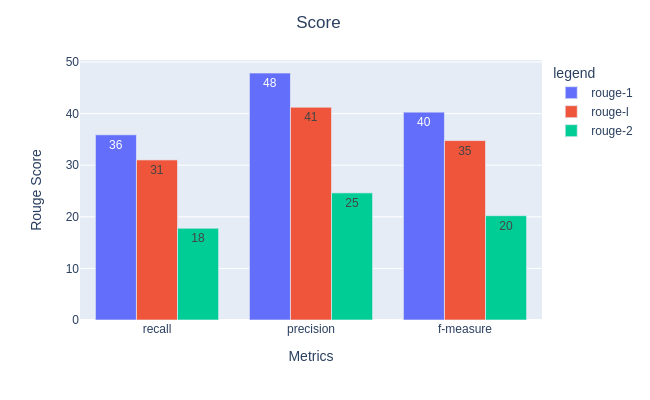

In [ ]:
fig = px.bar(BartRouge*100, x=BartRouge.index, y=BartRouge.columns, 
             barmode='group', 
             text_auto='.2s',
             labels={
                     "Algo": "Algorithms",
                     "value": "Rouge Score",
                     "variable": "legend",
                     'index': "Metrics"
                 })
fig.update_layout( width=650,
                  height=400,
                title={
                  'text': "Score",
                  'y':.96,
                  'x':0.49,
                  'xanchor': 'center',
                  'yanchor': 'top'})

fig.show()

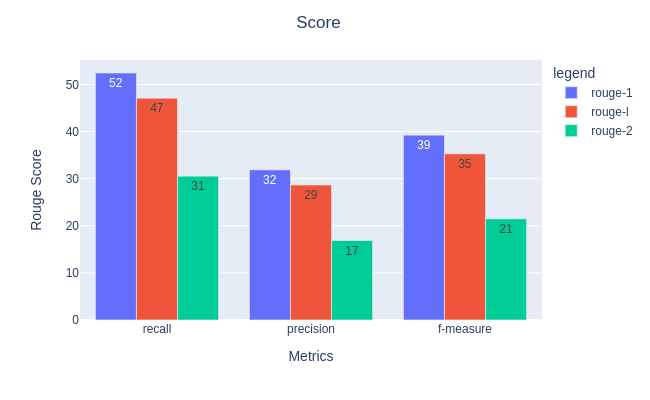

### **Sample Summaries**

In [111]:
[i for i in Summaries['GoldSummary'][:5]]

['बिहार में भारतीय जनता पार्टी (बीजेपी) अपने सहयोगी जनता दल यूनाइटेड (जेडीयू) और लोक जनशक्ति पार्टी (एलजेपी) से क़दम-क़दम पर समझौता करने को विवश दिख रही है.',
 'क्रिस गेल ने कहा चैंपियंस ट्रॉफी में पाकिस्तानी पर भारी पड़ेगा भारत क्रिस गेल ने पाकिस्तान को पंसदीदा टीम बताया 18 जून से इंग्लैंड और वेल्स में शुरू होगा चैम्पियंस ट्रॉफी टूर्नामेंट',
 'म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान ने कहा कि वह तब तक बातचीत नहीं करेंगे जब तक लोग प्रदर्शन बंद कर अपने घरों को नहीं लौटेंगे।',
 'ट्विंकल खन्ना ने वजाइना से जुड़े कई सवालों के दिए जवाब. ट्विंकल खन्ना ने सोशल मीडिया पर शेयर की पोस्ट. ट्विंकल खन्ना ने अपने ब्लॉक में दिए 11 सवालों के जवाब.',
 'दुनिया भर में ग़लत तरीके से सड़क पार करने पर जुर्माना लगाए जाने का प्रावधान है लेकिन अमरीका में ऐसी ग़लती करने पर जिस तरह के क़ायदे कानून हैं, वह किसी भी विदेशी आगंतुक को चौंका सकता है.']

In [115]:
[i for i in Summaries['T5Summary'][:5]]

['बिहार में विधानसभा चुनावों के लिए बीजेपी और जनता दल यूनाइटेड (जेडीयू) जैसे तीनों घटक राजनीतिक दलों की उम्मीदवारी लड़ने की तैयारी कर रहे हैं.',
 'आईसीसी चैम्पियंस ट्रॉफी में अगले महीने भारत और पाकिस्तान के बीच होने वाले मुकाबले में भारत का पलड़ा भारी रहेगा.',
 'मिस्र के राष्ट्रपति हुस्नी मुबारक ने सरकार विरोधी प्रदर्शनकारियों के साथ बातचीत शुरू करने का आग्रह किया है.',
 'बॉलीवुड की एक्ट्रेस ट्विंकल खन्ना ने एक और ब्लॉग लिखते हुए 11 सवालों के जवाब दिए हैं.',
 'अमरीका में लाल बत्ती पर सड़क पार करने पर रोक लगा दी गई है और इसके लिए कई लोगों को जुर्माना लगाया गया है.']

In [116]:
[i for i in Summaries['BartSummary'][:5]]

['आगामी लोकसभा चुनाव में राज्य की कुल 40 सीटों में से जिन सीटों पर राष्ट्रीय जनतांत्रिक गठबंधन (एनडीए) के ये तीनों घटक चुनाव लड़ेंगे, उनकी सूची से भी बीजेपी की मजबूरी झलक उठती है. यानी राज्य के मुख्यमंत्री और जेडीयू के अध्यक्ष नीतीश कुमार ने सीटों के चयन में अपने दलीय हित के अनुकूल बीजेपी नेतृत्व को जैसे',
 'वेस्टइंडीज के आक्रामक बल्लेबाज क्रिस गेल ने कहा है कि अगले महीने शुरू होने वाली आईसीसी चैम्पियंस ट्रॉफी में भारत और पाकिस्तान के बीच होने वाले मुकाबले में भारत का पलड़ा भारी रहेगा. भारत और पाकिस्तान चार जून को चैम्पियंस ट्रॉफी में आमने सामने होंगे. गेल ने हालांकि भारत और पाकिस्तान को अपनी पसंदीदा टीमें भी बताया.एक कार्यक्रम',
 'म्रिस्र के नवनियुक्त उप राष्ट्रपति उमर सुलेमान ने बुधवार को कहा कि वह विपक्ष के साथ तब तक बातचीत नहीं करेंगे जब तक लोग प्रदर्शन बंद कर अपने घरों को नहीं लौटेंगे। समाचार एजेंसी डीपीए के मुताबिक सुलेमान ने कहा "राष्ट्रपति हुस्नी मुबारक ने विपक्ष के साथ बातचीत शुरू करने का आग्रह किया है लेकिन यह तब तक',
 'अकसर अपने ट्वीट्स को लेकर चर्चा में रहने वाली बॉलीवुड के

Note: Plotly plots are not rendering after saving notebook, so I kept same graph as image file.